# Read Me

## 고려대학교 식품자원경제학과 학사학위 졸업논문 "딥러닝을 이용한 가격예측 연구의 검증 및 개선 방안"에 쓰인 코드입니다.

## 졸업논문 링크: https://drive.google.com/file/d/1G9E3sRjS1GARbnvge4UTe46C9oFmfZO1/view





# Data

In [ ]:
import pandas as pd
import numpy as np
price_2017 = pd.read_csv('광주_무_2017.csv')
price_2018 = pd.read_csv('광주_무_2018.csv')
price_2019 = pd.read_csv('광주_무_2019.csv')
price_2020 = pd.read_csv('광주_무_2020.csv')
price_2020 = price_2020.dropna()
price_2021 = pd.read_csv('광주_무_2021.csv')

temperature = pd.read_csv('광주_평균기온.csv', encoding='cp949')
humidity = pd.read_csv('광주_평균상대습도.csv', encoding='cp949')
wind = pd.read_csv('광주_평균풍속.csv', encoding='cp949')
CPI = pd.read_csv('소비자물가지수.csv')

def check_nan(df):
  print(df.isna().sum())

data_list = [price_2017, price_2018, price_2019, price_2020, price_2021, temperature, humidity, wind, CPI]
for df in data_list:
  check_nan(df)

일자    0
무     0
dtype: int64
일자    0
무     0
dtype: int64
일자    0
무     0
dtype: int64
일자    0
무     0
dtype: int64
일자    0
무     0
dtype: int64
날짜         0
지점         1
평균기온(℃)    1
최저기온(℃)    1
최고기온(℃)    1
dtype: int64
\t\t지점번호     0
지점명          3
일시           3
평균습도(%rh)    3
최저습도(%rh)    3
dtype: int64
\t\t지점번호         0
지점명              4
일시               4
평균풍속(m/s)        6
최대풍속(m/s)        5
최대풍속풍향(deg)      5
\t최대풍속시각         5
최대순간풍속(m/s)      5
최대순간풍속풍향(deg)    5
\t최대순간풍속시각       5
dtype: int64
일자     0
CPI    0
dtype: int64


<ipython-input-2-11db21ce44e8>:75: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CPI['일자'] = pd.to_datetime(CPI['일자'].str.replace('.', '-') + '-01')
<ipython-input-2-11db21ce44e8>:77: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  CPI.iloc[:,0] = CPI.iloc[:, 0].astype(float)


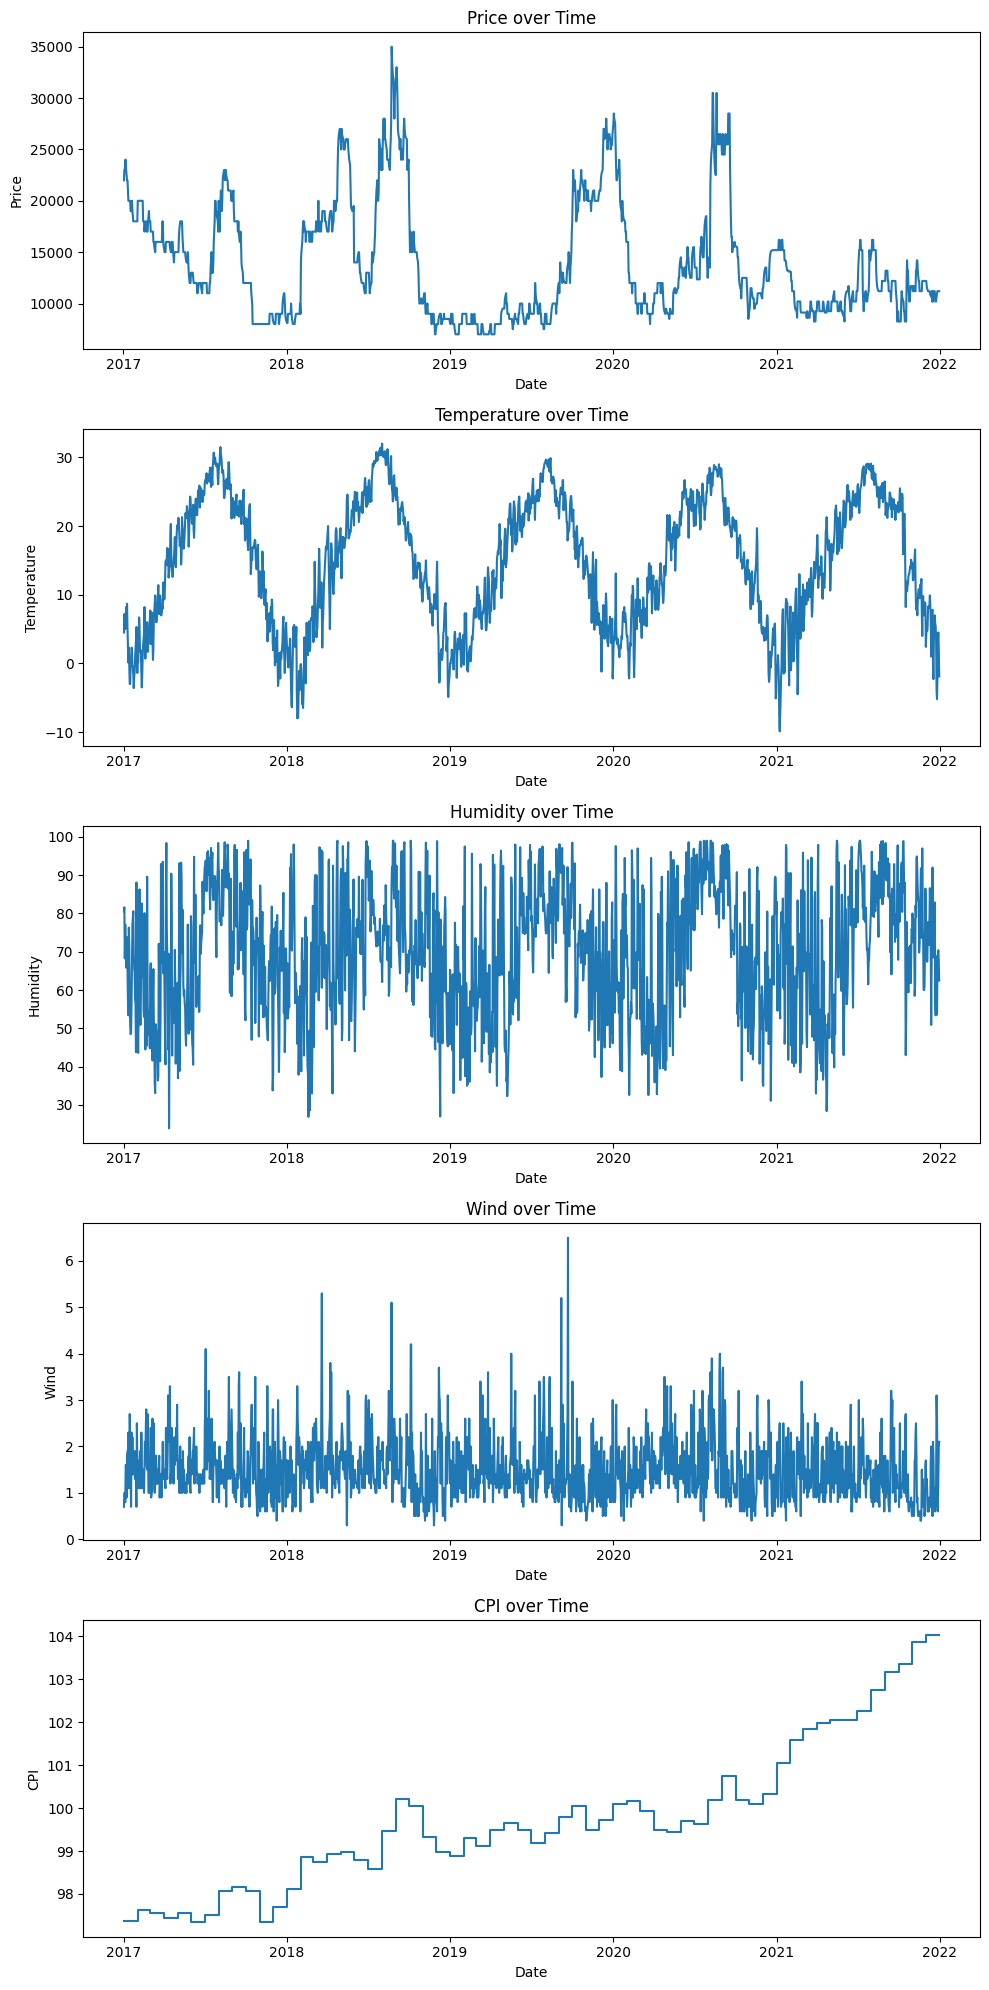

,date,price,temperature,humidity,wind,CPI
0,2017-01-02,22000.0,7.2,81.6,1.0,97.366
1,2017-01-03,23000.0,5.7,68.3,1.0,97.366
2,2017-01-04,23000.0,5.0,77.1,0.8,97.366
3,2017-01-05,24000.0,6.8,71.3,1.6,97.366
4,2017-01-06,24000.0,8.2,65.9,1.6,97.366
...,...,...,...,...,...,...
1820,2021-12-27,11200.0,-2.1,65.9,1.6,104.040
1821,2021-12-28,11200.0,3.3,69.3,0.6,104.040
1822,2021-12-29,11200.0,4.5,70.4,1.3,104.040
1823,2021-12-30,11200.0,1.9,67.1,2.0,104.040


In [ ]:
def clean_and_reformat_date(df, year):
    #숫자 문자만 남긴다.
    df['일자'] = df['일자'].str.replace(r'\D', '', regex=True)
    df['일자'] = pd.to_datetime(df['일자'].apply(lambda x: f"{year}-{x[:2]}-{x[2:]}"))
    return df

# Apply the function to each DataFrame
price_2017 = clean_and_reformat_date(price_2017, '2017')
price_2018 = clean_and_reformat_date(price_2018, '2018')
price_2019 = clean_and_reformat_date(price_2019, '2019')
price_2020 = clean_and_reformat_date(price_2020, '2020')
price_2021 = clean_and_reformat_date(price_2021, '2021')

# Concatenate all the DataFrames in order from 2017 to 2021
price = pd.concat([price_2017, price_2018, price_2019, price_2020, price_2021], ignore_index=True)

price['무'] = price['무'].str.replace(',', '', regex=True)
price['무'] = price['무'].astype(int)

price = price.sort_values(by='일자').reset_index(drop=True)
price.columns = ['date', 'price']

# Convert 'date' to datetime format and set it as the index
price['date'] = pd.to_datetime(price['date'])
price.set_index('date', inplace=True)

# Create a complete date range from 2017 to 2021
complete_date_range = pd.date_range(start='2017-01-01', end='2021-12-31')

# Reindex the DataFrame
price_reindexed = price.reindex(complete_date_range)

# 공휴일 가격 결측치 처리
price_reindexed = price_reindexed.iloc[ 1: ,:]
# 앞이 없는 1월 1일은 버리고, 나머지 공휴일은 앞뒤 평균으로
for missing_date in price_reindexed[price_reindexed['price'].isna()].index:
    before = price_reindexed.loc[:missing_date].dropna().index.max()
    after = price_reindexed.loc[missing_date:].dropna().index.min()
    mean_price = np.mean([price_reindexed.loc[before, 'price'], price_reindexed.loc[after, 'price']])
    price_reindexed.loc[missing_date, 'price'] = mean_price
# price_reindexed = price_reindexed.fillna(price_reindexed.interpolate())

price_reindexed.reset_index(inplace=True)
price_reindexed.columns = ['date', 'price']


# Remove '\t' from the '날짜' column
temperature['날짜'] = temperature['날짜'].str.replace('\t', '', regex=False)

# Keep only the '날짜' and '평균기온(℃)' columns and rename them
temperature = temperature[['날짜', '평균기온(℃)']].rename(columns={'날짜': 'date', '평균기온(℃)': 'temperature'})

# Keep only the '일시' and '평균습도(%rh)' columns and rename them
humidity = humidity[['일시', '평균습도(%rh)']].rename(columns={'일시': 'date', '평균습도(%rh)': 'humidity'})

# Keep only the '일시' and '평균풍속' columns and rename them
wind = wind[['일시', '평균풍속(m/s)']].rename(columns={'일시': 'date', '평균풍속(m/s)': 'wind'})

# First, ensure the 'date' columns are in the same datetime format
price_reindexed['date'] = pd.to_datetime(price_reindexed['date'])
temperature['date'] = pd.to_datetime(temperature['date'])
humidity['date'] = pd.to_datetime(humidity['date'])
wind['date'] = pd.to_datetime(wind['date'])

# Merge the DataFrames
merged_df = pd.merge(price_reindexed, temperature, on='date', how='inner')
merged_df = pd.merge(merged_df, humidity, on='date', how='inner')
merged_df = pd.merge(merged_df, wind, on='date', how='inner')

# Optionally, sort by date
merged_df = merged_df.sort_values(by='date').reset_index(drop=True)


# 월별 소비자물가지수를 일별로
CPI['일자'] = pd.to_datetime(CPI['일자'].str.replace('.', '-') + '-01')
CPI.set_index('일자', inplace=True)
CPI.iloc[:,0] = CPI.iloc[:, 0].astype(float)
last_date = pd.to_datetime("2021-12-31")
last_value = CPI.loc[pd.to_datetime("2021-12-01"), 'CPI']  # Assuming the last available CPI value is for December 2021
CPI.loc[last_date] = last_value
CPI.sort_index(inplace=True)

CPI_daily = CPI.resample('D').ffill()
CPI_daily.reset_index(inplace=True)
CPI_daily.columns=['date', 'CPI']

merged_df['date'] = pd.to_datetime(merged_df['date'])

CPI_daily.reset_index(drop=True, inplace=True)
merged_df.reset_index(drop=True, inplace=True)
final_df = pd.merge(merged_df, CPI_daily, on='date', how='left')
final_df = final_df.sort_values(by='date').reset_index(drop=True)


CPI.reset_index(inplace=True)
CPI.columns = ['date', 'CPI']
import matplotlib.pyplot as plt

# List of DataFrames to plot
dfs_to_plot = [price_reindexed, temperature, humidity, wind, CPI]
# Corresponding titles for the plots
titles = ['Price', 'Temperature', 'Humidity', 'Wind', 'CPI']

# Create a 5x1 grid of subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# Loop through the DataFrames and their corresponding titles to plot them
for i, (df, title) in enumerate(zip(dfs_to_plot, titles)):
    # If the plot is for CPI, use step plot
    if title == "CPI":
        axes[i].step(df.iloc[:, 0], df.iloc[:, 1], where='post')
    else:
        axes[i].plot(df.iloc[:, 0], df.iloc[:, 1])
    axes[i].set_title(f"{title} over Time")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(title)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# final_df.isna().sum() - 2개
final_df.dropna(inplace=True)
final_df.isna().sum()
final_df

# LSTM 검증

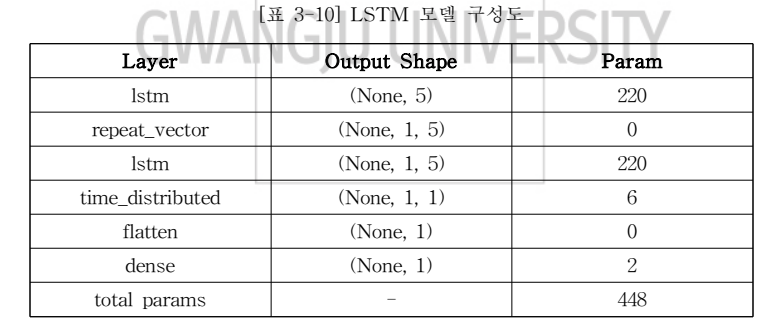

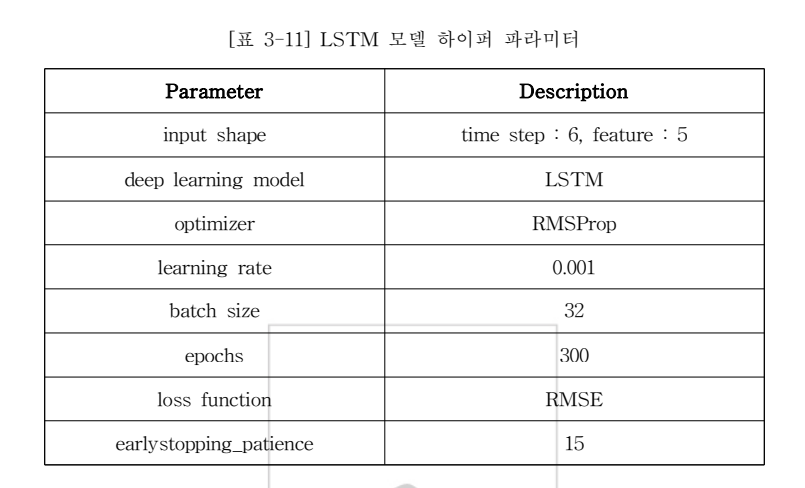

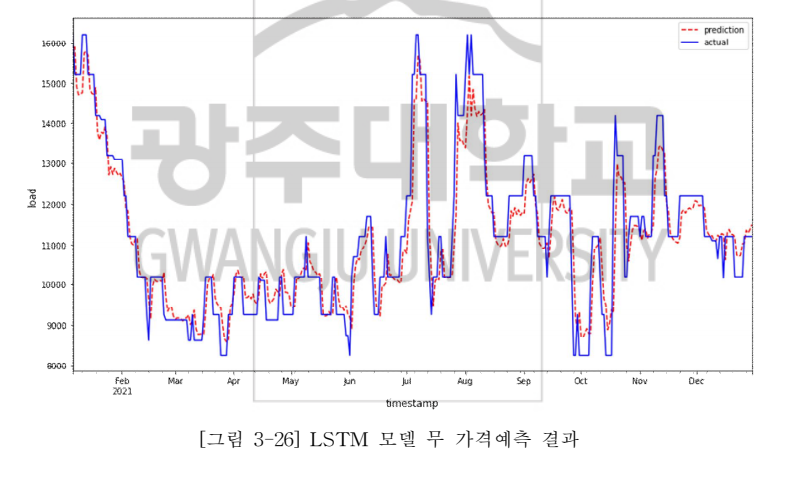

## 논문 그대로의 가격예측과 어제의 가격과 비교

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import numpy as np


# 1.data  2.model 3.train 4.test
'''==================== Data ===================='''
# min-max scale, date 제외
scaler = MinMaxScaler()
final_df_scaled = pd.DataFrame()
for col in final_df.columns:
    if col != 'date':
        scaled_values = scaler.fit_transform(final_df[[col]])
        final_df_scaled[col] = scaled_values.flatten()
    else:
        final_df_scaled[col] = final_df[col]
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# 2021은 test로
final_df_scaled['date'] = pd.to_datetime(final_df_scaled['date'])
train_data = final_df_scaled[final_df_scaled['date'] < '2021-01-01']
test_data = final_df_scaled[final_df_scaled['date'] >= '2021-01-01']

all_features = ['price', 'temperature', 'humidity', 'wind', 'CPI']
x_train = np.array(train_data[all_features])
y_train = np.array(train_data[['price']])
x_test = np.array(test_data[all_features])
y_test = np.array(test_data[['price']])

# windowsize로 나눈다.
window_size = 6

def create_sequences(data, label, window_size):
    seq_data, seq_label = [], []
    for i in range(len(data) - window_size):
        seq_data.append(data[i:i+window_size])
        seq_label.append(label[i+window_size])
    return np.array(seq_data), np.array(seq_label)


x_train_seq, y_train_seq = create_sequences(x_train, y_train, window_size)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, window_size)

# Reshape for LSTM [samples, timesteps, features]
x_train_seq = np.reshape(x_train_seq, (x_train_seq.shape[0], window_size, x_train.shape[1]))
x_test_seq = np.reshape(x_test_seq, (x_test_seq.shape[0], window_size, x_test.shape[1]))


'''==================== Model ===================='''
model = Sequential()
model.add(LSTM(5, activation='tanh', input_shape=(window_size, 5))) # activation='tanh',
model.add(RepeatVector(1))
model.add(LSTM(5,activation='linear', return_sequences=True)) # activation='tanh',
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())
model.add(Dense(1))


optimizer = RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=root_mean_squared_error)
model.summary()


'''==================== Train ===================='''

# Initialize EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='loss', patience=15)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True)

# Train the model
history = model.fit(
    x_train_seq, y_train_seq,
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 5)                 220       
                                                                 
 repeat_vector_20 (RepeatVe  (None, 1, 5)              0         
 ctor)                                                           
                                                                 
 lstm_41 (LSTM)              (None, 1, 5)              220       
                                                                 
 time_distributed_20 (TimeD  (None, 1, 1)              6         
 istributed)                                                     
                                                                 
 flatten_20 (Flatten)        (None, 1)                 0         
                                                                 
 dense_41 (Dense)            (None, 1)               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 0s 8ms/step - loss: 0.2086
Epoch 3/300
46/46 [==============================] - 0s 9ms/step - loss: 0.1874
Epoch 4/300
46/46 [==============================] - 0s 9ms/step - loss: 0.1509
Epoch 5/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0955
Epoch 6/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0702
Epoch 7/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0623
Epoch 8/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0584
Epoch 9/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0559
Epoch 10/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 11/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0527
Epoch 12/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0517
Epoch 13/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0502
Epoch 14/300
46/46 [============================

pred_y, y_test_seq

12/12 [==============================] - 1s 4ms/step


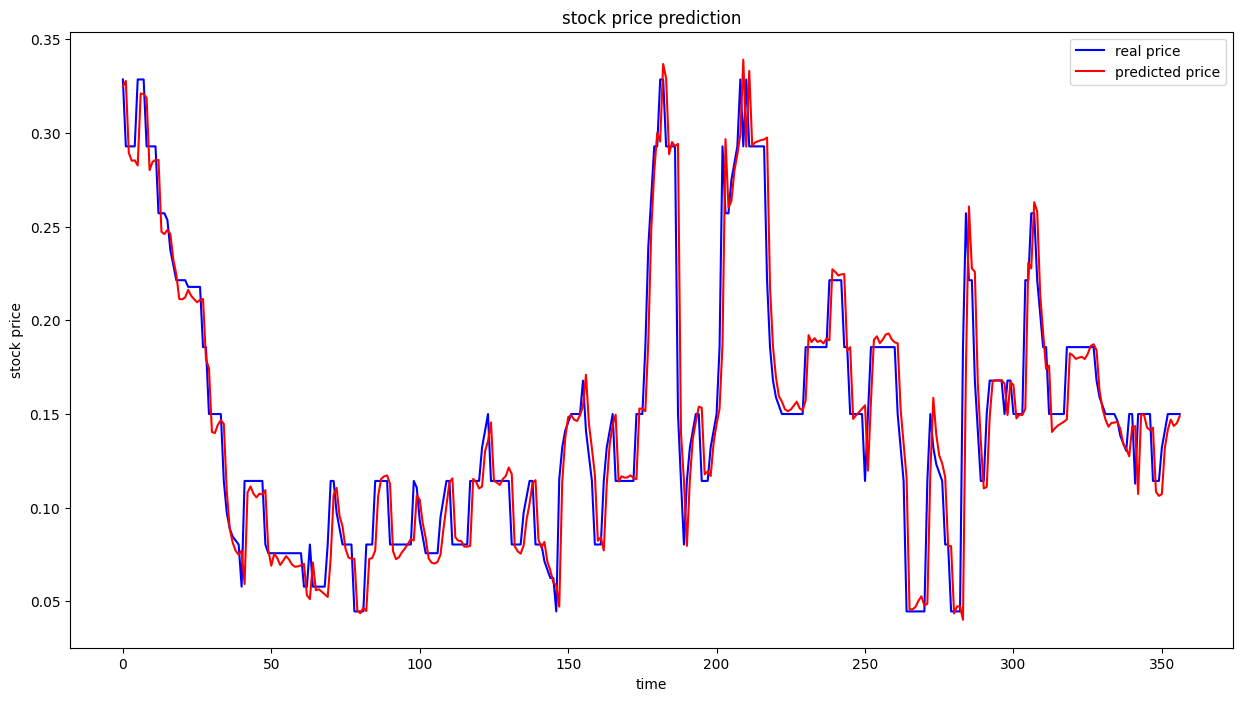

Mean Absolute Percentage Error: 10.345908194855037%
Root Mean Squared Error: 0.0225976496914806


In [ ]:
'''==================== Test ===================='''
import numpy as np
model.load_weights('best_model.h5')

pred_y = model.predict(x_test_seq)

plt.figure(figsize=(15, 8))
plt.plot(y_test_seq, color='blue', label='real price')
plt.plot(pred_y,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error_rate = mean_absolute_percentage_error(y_test_seq, pred_y)
print(f"Mean Absolute Percentage Error: {error_rate}%")


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

rmse = root_mean_squared_error(y_test_seq, pred_y)
print(f"Root Mean Squared Error: {rmse}")

어제의 가격과 비교
pred_y_shifted, y_test_seq_adjusted

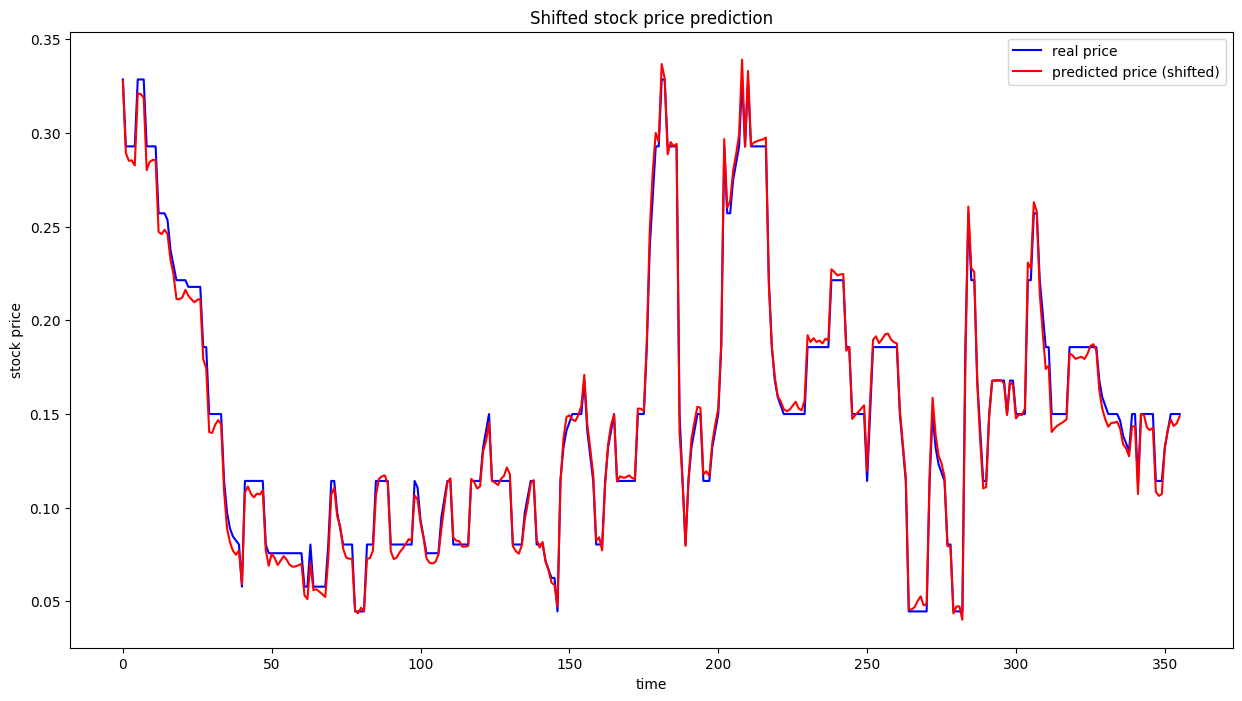

Shifted Mean Absolute Percentage Error: 3.2337935946026803%
Shifted Root Mean Squared Error: 0.00500055287646167


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

day_shift = 1
# Shift pred_y by 1 row and drop the last value
pred_y_shifted = pred_y[day_shift:]

# Drop the first row of y_test_seq
y_test_seq_adjusted = y_test_seq[:-day_shift]

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(y_test_seq_adjusted, color='blue', label='real price')
plt.plot(pred_y_shifted, color='red', label='predicted price (shifted)')
plt.title('Shifted stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error_rate = mean_absolute_percentage_error(y_test_seq_adjusted, pred_y_shifted)
print(f"Shifted Mean Absolute Percentage Error: {error_rate}%")

# Calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

rmse = root_mean_squared_error(y_test_seq_adjusted, pred_y_shifted)
print(f"Shifted Root Mean Squared Error: {rmse}")

## 상승 하락으로 성능 평가

12/12 [==============================] - 0s 2ms/step


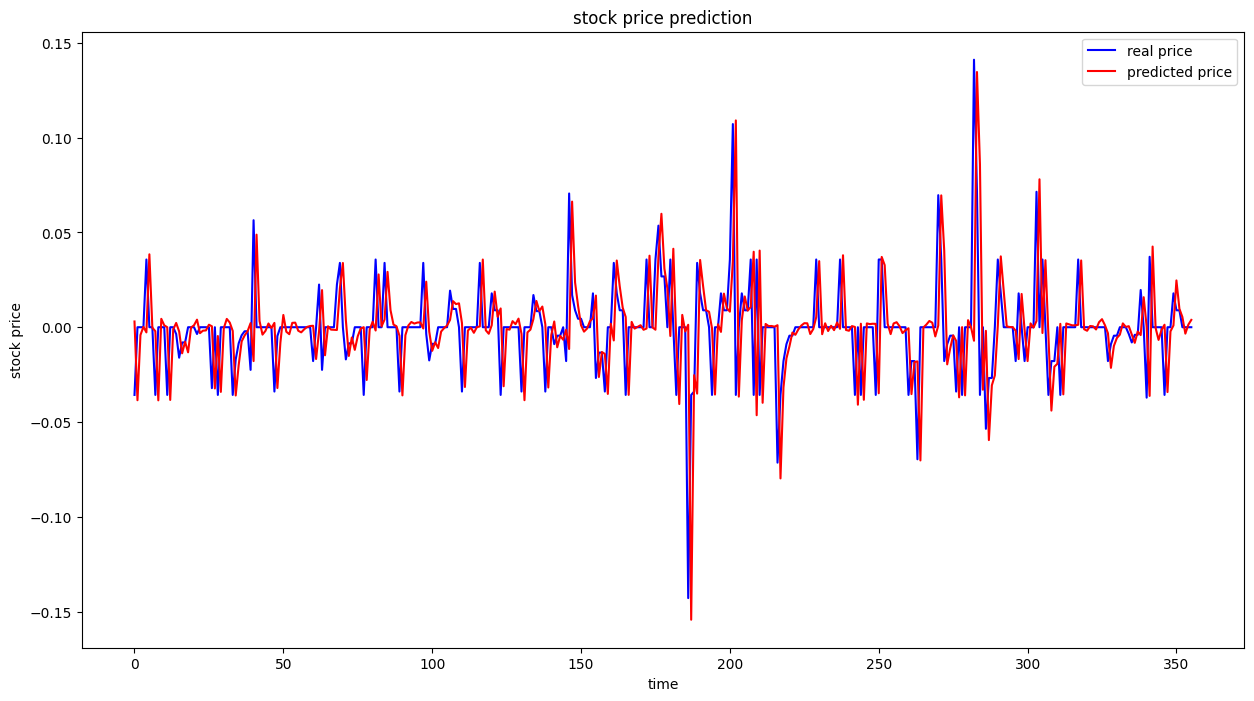

Number of times the signs are the same: 104
Percentage of times the signs are the same: 29.213483146067414%
Mean Absolute Percentage Error: 5755696106.563969%


In [ ]:
'''==================== Test ===================='''
import numpy as np
model.load_weights('best_model.h5')
pred_y = model.predict(x_test_seq)
pred_y_diff = np.diff(pred_y, axis=0)
y_test_seq_diff =np.diff(y_test_seq, axis=0)

plt.figure(figsize=(15, 8))
plt.plot(y_test_seq_diff, color='blue', label='real price')
plt.plot(pred_y_diff,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# Get the sign of each element in the arrays
sign_pred_y_diff = np.sign(pred_y_diff)
sign_y_test_seq_diff = np.sign(y_test_seq_diff)

# Compare the signs and count the number of times they are the same
same_sign_count = np.sum(sign_pred_y_diff == sign_y_test_seq_diff)

# Calculate the percentage of times the signs are the same
total_count = len(sign_pred_y_diff)
percentage_same_sign = (same_sign_count / total_count) * 100

print(f"Number of times the signs are the same: {same_sign_count}")
print(f"Percentage of times the signs are the same: {percentage_same_sign}%")


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

error_rate = mean_absolute_percentage_error(y_test_seq_diff, pred_y_diff)
print(f"Mean Absolute Percentage Error: {error_rate}%")

마찬 가지로 t기예측을 t-1기 상승하락과 비교

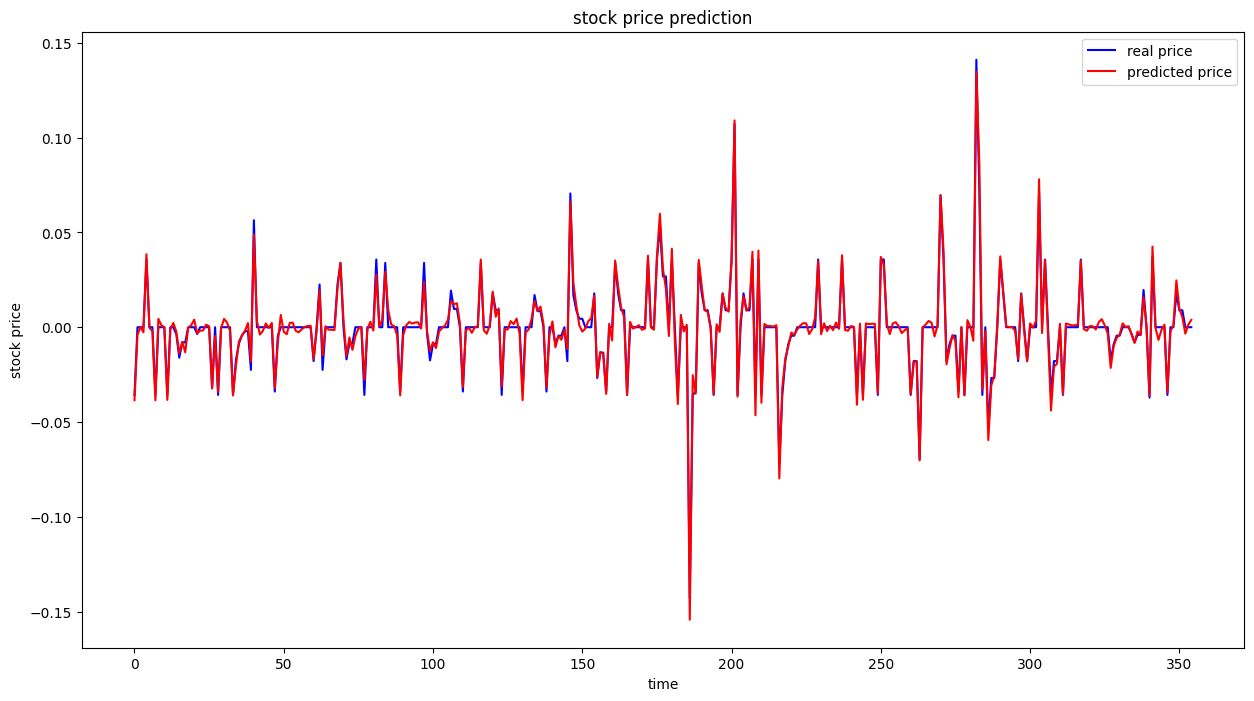

Number of times the signs are the same: 155
Percentage of times the signs are the same: 43.66197183098591%
Mean Absolute Percentage Error: 1141098631.5889492%


In [ ]:
'''==================== Test ===================='''
import numpy as np #pred_y_shifted, y_test_seq_adjusted

pred_y_diff = np.diff(pred_y_shifted, axis=0)
y_test_seq_diff =np.diff(y_test_seq_adjusted, axis=0)

plt.figure(figsize=(15, 8))
plt.plot(y_test_seq_diff, color='blue', label='real price')
plt.plot(pred_y_diff,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# Get the sign of each element in the arrays
sign_pred_y_diff = np.sign(pred_y_diff)
sign_y_test_seq_diff = np.sign(y_test_seq_diff)

# Compare the signs and count the number of times they are the same
same_sign_count = np.sum(sign_pred_y_diff == sign_y_test_seq_diff)

# Calculate the percentage of times the signs are the same
total_count = len(sign_pred_y_diff)
percentage_same_sign = (same_sign_count / total_count) * 100

print(f"Number of times the signs are the same: {same_sign_count}")
print(f"Percentage of times the signs are the same: {percentage_same_sign}%")


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

error_rate = mean_absolute_percentage_error(y_test_seq_diff, pred_y_diff)
print(f"Mean Absolute Percentage Error: {error_rate}%")

## 가격만 가지고 학습

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import numpy as np

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 1.data  2.model 3.train 4.test
'''==================== Data ===================='''
# min-max scale, date 제외
scaler = MinMaxScaler()
final_df_scaled = pd.DataFrame()
for col in final_df.columns:
    if col != 'date':
        scaled_values = scaler.fit_transform(final_df[[col]])
        final_df_scaled[col] = scaled_values.flatten()
    else:
        final_df_scaled[col] = final_df[col]


# 2021은 test로
final_df_scaled['date'] = pd.to_datetime(final_df_scaled['date'])
train_data = final_df_scaled[final_df_scaled['date'] < '2021-01-01']
test_data = final_df_scaled[final_df_scaled['date'] >= '2021-01-01']

all_features = ['price']
x_train = np.array(train_data[all_features])
y_train = np.array(train_data[['price']])
x_test = np.array(test_data[all_features])
y_test = np.array(test_data[['price']])

# windowsize로 나눈다.
window_size = 6

def create_sequences(data, label, window_size):
    seq_data, seq_label = [], []
    for i in range(len(data) - window_size):
        seq_data.append(data[i:i+window_size])
        seq_label.append(label[i+window_size])
    return np.array(seq_data), np.array(seq_label)


x_train_seq, y_train_seq = create_sequences(x_train, y_train, window_size)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, window_size)

# Reshape for LSTM [samples, timesteps, features]
x_train_seq = np.reshape(x_train_seq, (x_train_seq.shape[0], window_size, x_train.shape[1]))
x_test_seq = np.reshape(x_test_seq, (x_test_seq.shape[0], window_size, x_test.shape[1]))


'''==================== Model ===================='''
model = Sequential()
model.add(LSTM(5, activation='tanh', input_shape=(window_size, x_train.shape[1])))
model.add(RepeatVector(1))
model.add(LSTM(5, activation='linear', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())
model.add(Dense(1))


optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=root_mean_squared_error)
model.summary()


'''==================== Train ===================='''
# Initialize EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='loss', patience=15)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True)

# Train the model
history = model.fit(
    x_train_seq, y_train_seq,
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 5)                 140       
                                                                 
 repeat_vector_22 (RepeatVe  (None, 1, 5)              0         
 ctor)                                                           
                                                                 
 lstm_45 (LSTM)              (None, 1, 5)              220       
                                                                 
 time_distributed_22 (TimeD  (None, 1, 1)              6         
 istributed)                                                     
                                                                 
 flatten_22 (Flatten)        (None, 1)                 0         
                                                                 
 dense_45 (Dense)            (None, 1)               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 0s 8ms/step - loss: 0.2423
Epoch 3/300
46/46 [==============================] - 0s 8ms/step - loss: 0.1856
Epoch 4/300
46/46 [==============================] - 0s 9ms/step - loss: 0.1446
Epoch 5/300
46/46 [==============================] - 0s 8ms/step - loss: 0.0839
Epoch 6/300
46/46 [==============================] - 0s 8ms/step - loss: 0.0577
Epoch 7/300
46/46 [==============================] - 0s 8ms/step - loss: 0.0566
Epoch 8/300
46/46 [==============================] - 0s 8ms/step - loss: 0.0559
Epoch 9/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0553
Epoch 10/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 11/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 12/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 13/300
46/46 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 14/300
46/46 [============================

12/12 [==============================] - 1s 3ms/step


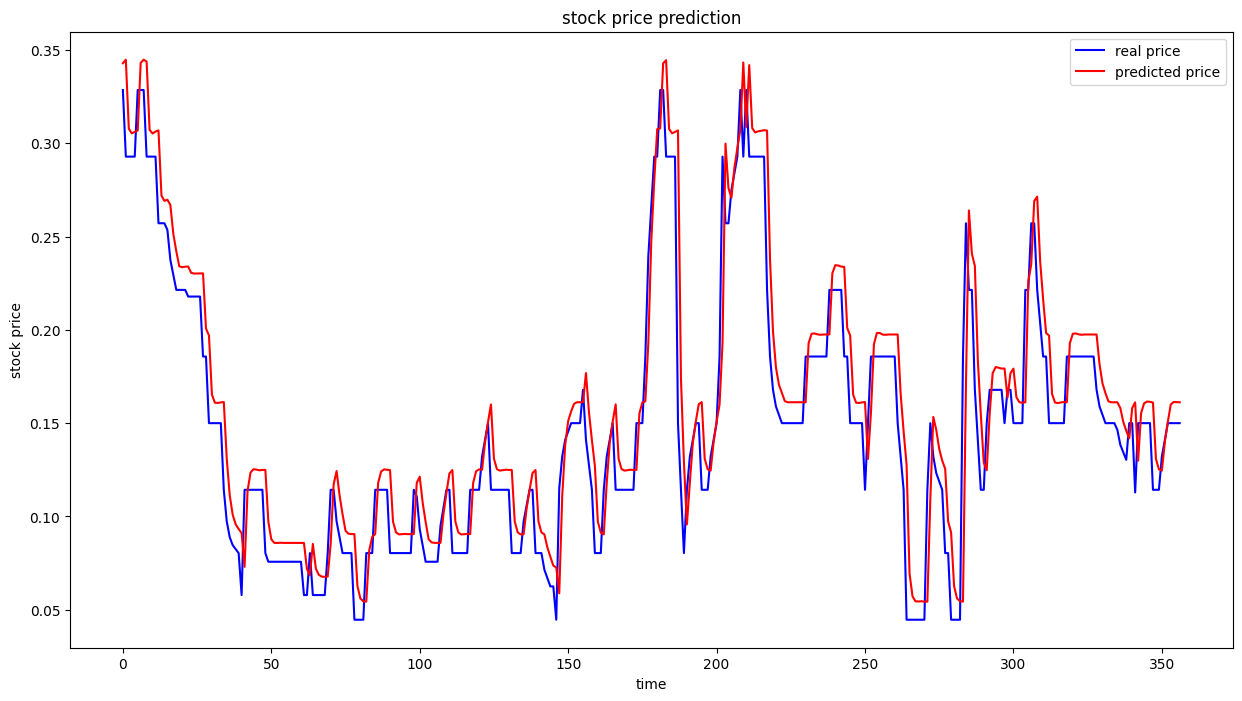

Mean Absolute Percentage Error: 16.040392871054074%
Root Mean Squared Error: 0.026234681708533214


In [ ]:
'''==================== Test ===================='''
import numpy as np
model.load_weights('best_model.h5')

pred_y = model.predict(x_test_seq)

plt.figure(figsize=(15, 8))
plt.plot(y_test_seq, color='blue', label='real price')
plt.plot(pred_y,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error_rate = mean_absolute_percentage_error(y_test_seq, pred_y)
print(f"Mean Absolute Percentage Error: {error_rate}%")


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
rmse = root_mean_squared_error(y_test_seq, pred_y)
print(f"Root Mean Squared Error: {rmse}")

한 칸 옮기기

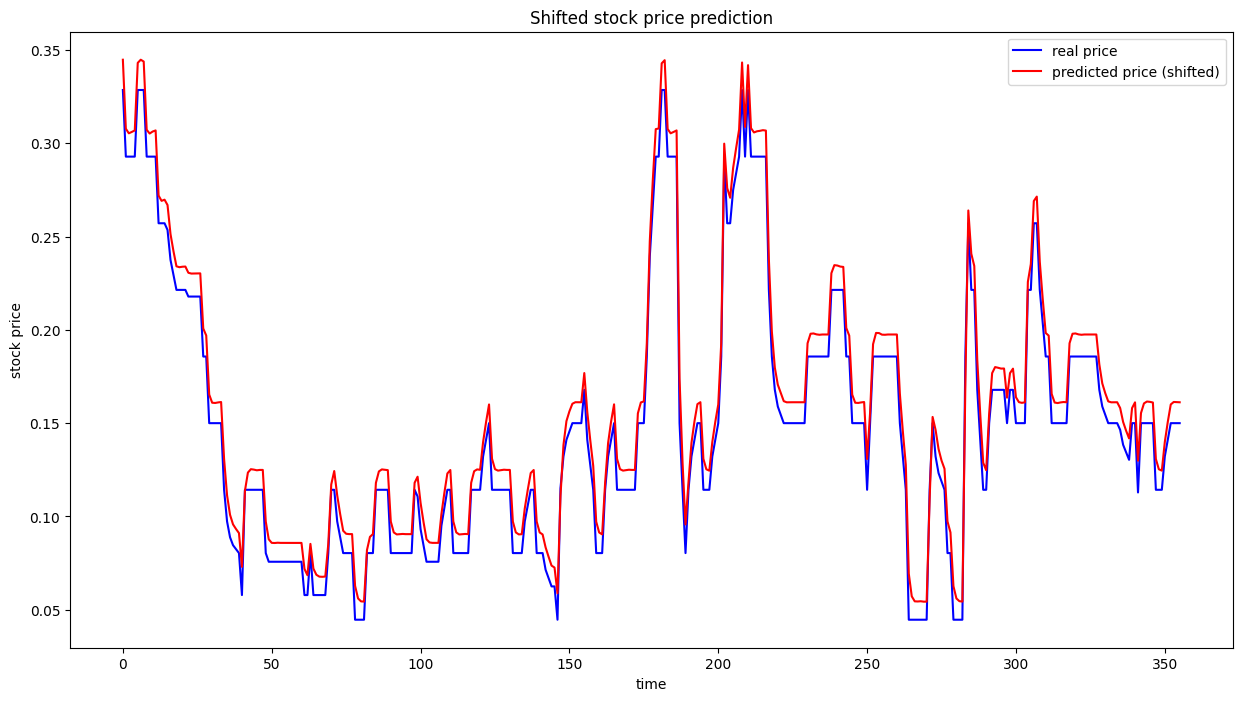

Shifted Mean Absolute Percentage Error: 9.588686773574102%
Shifted Root Mean Squared Error: 0.011865676826199267


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

day_shift = 1
# Shift pred_y by 1 row and drop the last value
pred_y_shifted = pred_y[day_shift:]

# Drop the first row of y_test_seq
y_test_seq_adjusted = y_test_seq[:-day_shift]

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(y_test_seq_adjusted, color='blue', label='real price')
plt.plot(pred_y_shifted, color='red', label='predicted price (shifted)')
plt.title('Shifted stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error_rate = mean_absolute_percentage_error(y_test_seq_adjusted, pred_y_shifted)
print(f"Shifted Mean Absolute Percentage Error: {error_rate}%")

# Calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

rmse = root_mean_squared_error(y_test_seq_adjusted, pred_y_shifted)
print(f"Shifted Root Mean Squared Error: {rmse}")

## 가격만 빼고 학습


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import numpy as np

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 1.data  2.model 3.train 4.test
'''==================== Data ===================='''
# min-max scale, date 제외
scaler = MinMaxScaler()
final_df_scaled = pd.DataFrame()
for col in final_df.columns:
    if col != 'date':
        scaled_values = scaler.fit_transform(final_df[[col]])
        final_df_scaled[col] = scaled_values.flatten()
    else:
        final_df_scaled[col] = final_df[col]


# 2021은 test로
final_df_scaled['date'] = pd.to_datetime(final_df_scaled['date'])
train_data = final_df_scaled[final_df_scaled['date'] < '2021-01-01']
test_data = final_df_scaled[final_df_scaled['date'] >= '2021-01-01']

all_features = ['temperature', 'humidity', 'wind', 'CPI']
x_train = np.array(train_data[all_features])
y_train = np.array(train_data[['price']])
x_test = np.array(test_data[all_features])
y_test = np.array(test_data[['price']])

# windowsize로 나눈다.
window_size = 6

def create_sequences(data, label, window_size):
    seq_data, seq_label = [], []
    for i in range(len(data) - window_size):
        seq_data.append(data[i:i+window_size])
        seq_label.append(label[i+window_size])
    return np.array(seq_data), np.array(seq_label)


x_train_seq, y_train_seq = create_sequences(x_train, y_train, window_size)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, window_size)

# Reshape for LSTM [samples, timesteps, features]
x_train_seq = np.reshape(x_train_seq, (x_train_seq.shape[0], window_size, x_train.shape[1]))
x_test_seq = np.reshape(x_test_seq, (x_test_seq.shape[0], window_size, x_test.shape[1]))


'''==================== Model ===================='''
model = Sequential()
model.add(LSTM(5, activation='tanh', input_shape=(window_size, 4)))
model.add(RepeatVector(1))
model.add(LSTM(5, activation='linear', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())
model.add(Dense(1))


optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=root_mean_squared_error)
model.summary()


'''==================== Train ===================='''
# Initialize EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='loss', patience=15)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True)

# Train the model
history = model.fit(
    x_train_seq, y_train_seq,
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 5)                 200       
                                                                 
 repeat_vector_24 (RepeatVe  (None, 1, 5)              0         
 ctor)                                                           
                                                                 
 lstm_49 (LSTM)              (None, 1, 5)              220       
                                                                 
 time_distributed_24 (TimeD  (None, 1, 1)              6         
 istributed)                                                     
                                                                 
 flatten_24 (Flatten)        (None, 1)                 0         
                                                                 
 dense_49 (Dense)            (None, 1)               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 0s 6ms/step - loss: 0.2086
Epoch 3/300
46/46 [==============================] - 0s 7ms/step - loss: 0.2077
Epoch 4/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2065
Epoch 5/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2056
Epoch 6/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2048
Epoch 7/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2041
Epoch 8/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2034
Epoch 9/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2032
Epoch 10/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2026
Epoch 11/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2027
Epoch 12/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2024
Epoch 13/300
46/46 [==============================] - 0s 6ms/step - loss: 0.2025
Epoch 14/300
46/46 [============================

12/12 [==============================] - 1s 2ms/step


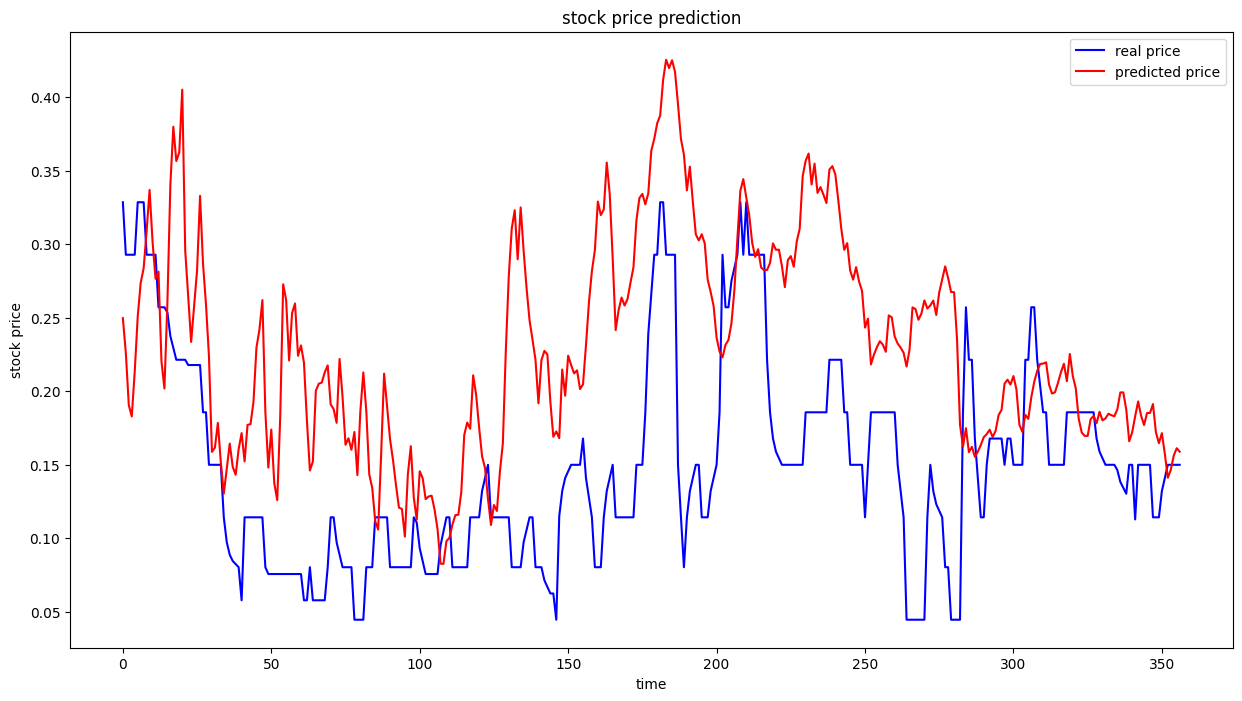

Mean Absolute Percentage Error: 87.54433090154737%
Root Mean Squared Error: 0.10948384376663496


In [ ]:
'''==================== Test ===================='''
import numpy as np
model.load_weights('best_model.h5')

pred_y = model.predict(x_test_seq)

plt.figure(figsize=(15, 8))
plt.plot(y_test_seq, color='blue', label='real price')
plt.plot(pred_y,color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error_rate = mean_absolute_percentage_error(y_test_seq, pred_y)
print(f"Mean Absolute Percentage Error: {error_rate}%")


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
rmse = root_mean_squared_error(y_test_seq, pred_y)
print(f"Root Mean Squared Error: {rmse}")



## Shapley


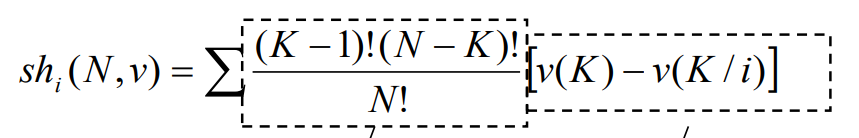http://contents.kocw.or.kr/document/lec/2012/ChungBuk/SongYangHoon/chapter5.pdf

열 / 행으로 나누고 average substitue.
그러나, 모델 자체가 average와 더 잘 맞는다면
제대로 파악하지 못할 수 있다.

 ### 종속 변수, 시간 별 Shapley

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import numpy as np


# 1.data  2.model 3.train 4.test
'''==================== Data ===================='''
# min-max scale, date 제외
scaler = MinMaxScaler()
final_df_scaled = pd.DataFrame()
for col in final_df.columns:
    if col != 'date':
        scaled_values = scaler.fit_transform(final_df[[col]])
        final_df_scaled[col] = scaled_values.flatten()
    else:
        final_df_scaled[col] = final_df[col]
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# 2021은 test로
final_df_scaled['date'] = pd.to_datetime(final_df_scaled['date'])
train_data = final_df_scaled[final_df_scaled['date'] < '2021-01-01']
test_data = final_df_scaled[final_df_scaled['date'] >= '2021-01-01']

all_features = ['price', 'temperature', 'humidity', 'wind', 'CPI']
x_train = np.array(train_data[all_features])
y_train = np.array(train_data[['price']])
x_test = np.array(test_data[all_features])
y_test = np.array(test_data[['price']])

# windowsize로 나눈다.
window_size = 6

def create_sequences(data, label, window_size):
    seq_data, seq_label = [], []
    for i in range(len(data) - window_size):
        seq_data.append(data[i:i+window_size])
        seq_label.append(label[i+window_size])
    return np.array(seq_data), np.array(seq_label)


x_train_seq, y_train_seq = create_sequences(x_train, y_train, window_size)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, window_size)

# Reshape for LSTM [samples, timesteps, features]
x_train_seq = np.reshape(x_train_seq, (x_train_seq.shape[0], window_size, x_train.shape[1]))
x_test_seq = np.reshape(x_test_seq, (x_test_seq.shape[0], window_size, x_test.shape[1]))


'''==================== Model ===================='''
model = Sequential()
model.add(LSTM(5, activation='tanh', input_shape=(window_size, 5))) # activation='tanh',
model.add(RepeatVector(1))
model.add(LSTM(5,activation='linear', return_sequences=True)) # activation='tanh',
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())
model.add(Dense(1))


optimizer = RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=root_mean_squared_error)
model.summary()


'''==================== Train ===================='''

# Initialize EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='loss', patience=15)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True)

# Train the model
history = model.fit(
    x_train_seq, y_train_seq,
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 220       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 5)              0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 5)              220       
                                                                 
 time_distributed (TimeDist  (None, 1, 1)              6         
 ributed)                                                        
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 0s 6ms/step - loss: 0.2163
Epoch 3/300
46/46 [==============================] - 0s 6ms/step - loss: 0.1931
Epoch 4/300
46/46 [==============================] - 0s 6ms/step - loss: 0.1648
Epoch 5/300
46/46 [==============================] - 0s 7ms/step - loss: 0.1167
Epoch 6/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0774
Epoch 7/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0681
Epoch 8/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0635
Epoch 9/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0598
Epoch 10/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0576
Epoch 11/300
46/46 [==============================] - 0s 6ms/step - loss: 0.0547
Epoch 12/300
46/46 [==============================] - 0s 7ms/step - loss: 0.0525
Epoch 13/300
46/46 [==============================] - 0s 10ms/step - loss: 0.0503
Epoch 14/300
46/46 [===========================

In [ ]:
import itertools
from math import factorial
import numpy as np
# accuracy check functon
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

def modify_with_avg_except_for_row(x_test_seq, modified_combination):
    modified_x_test_seq = np.copy(x_test_seq)

    for data_index in range(x_test_seq.shape[0]):
        for i in range(x_test_seq.shape[1]):
            if i not in modified_combination:
                modified_x_test_seq[data_index, i, :] = 0

    return modified_x_test_seq


def modify_with_avg_except_for_col(x_test_seq, modified_combination):
    modified_x_test_seq = np.copy(x_test_seq)

    for data_index in range(x_test_seq.shape[0]):
        for j in range(x_test_seq.shape[2]):
            if j not in modified_combination:
                modified_x_test_seq[data_index, :, j] = 0

    return modified_x_test_seq



# SHAP
# Train 단계에서의 SHAP가 아니라 predict 단계에서의 SHAP.
# RNN계열은 아예 train부터 빼면 시계열의 의미가 퇴색될 수 있다.
def shap_LSTM_row_col(model, x_test_seq, y_test_seq, number, root_mean_squared_error):
  '''
  Parameters:
  model (LSTM)
  test data x, y
  number to calculate SHAP
  function to calculate the Value
  '''
  ''''============= Data ============='''
  # SHAP 계산에 쓸 개수만 남긴다.
  x_test_seq = x_test_seq[:number]
  y_test_seq = y_test_seq[:number]

  window_size = len(x_test_seq[0]) # 시계열 크기
  feature_num = len(x_test_seq[0][0]) # 설명 변수 개수

  # Factorial Dict 선언
  factorial_dict = {}
  # 계산 시간을 줄이기 위한 팩토리얼 사전
  if window_size > feature_num:
    for n in range(window_size):
      factorial_dict[n] = factorial(n)
  else:
    for n in range(feature_num):
      factorial_dict[n] = factorial(n)

  # v(K) - v(K/i) Dict 선언
  v_values_dict_row = {}
  v_values_dict_col = {}

  row_shap = {} # SHAP dict for time
  col_shap = {} # SHAP dict for feature
  returning_shap = {} # return dict

  process = 0
  rows = []
  cols = []

  ''''============= Feature ============='''
  # cols
  for i in range(feature_num):
    cols.append(i)
  # start
  for i in range(feature_num):
    process += 1
    print("Now we are at Feature SHAP:", process/feature_num * 100,"%")
    cols.remove(i) # i 는 항상 포함시킬 것이기 때문에 일단 빼고 뽑느다.
    shap = 0
    for K in range(0,feature_num):
      nCr = itertools.combinations(cols, K)
      for combination in nCr: # every Combination Loop
        modified_combination = sorted(combination)
        ##### v(K/i) ####
        if tuple(modified_combination) not in v_values_dict_col:
          modified_data = modify_with_avg_except_for_col(x_test_seq, modified_combination) # 포함되지 않은 행들을 대체
          pred_y = model.predict(modified_data, verbose=0)
          v_K_without_i = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict_col[tuple(modified_combination)] = v_K_without_i
        else:
          v_K_without_i = v_values_dict_col[tuple(modified_combination)]

        #### v(K) ####
        modified_combination.append(i)
        if tuple(modified_combination) not in v_values_dict_col:
          modified_x_test_seq = modify_with_avg_except_for_col(x_test_seq, modified_combination) # 포함되지 않은 열들을 대체
          pred_y = model.predict(modified_x_test_seq, verbose=0)
          v_K = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict_col[tuple(modified_combination)] = v_K
        else:
          v_K = v_values_dict_col[tuple(modified_combination)]


        factorial_n = factorial_dict[n]
        factorial_k_1 = factorial_dict[K]
        facotrial_n_k = factorial_dict[feature_num-K-1]  # i 가 포함된 것이니 원래 공식보다 K에 1 더한다

        #### 최종 공식 ####
        shap += ((factorial_k_1 * facotrial_n_k) / factorial_n) * (v_K_without_i - v_K) # error니까 반대로 빼주기

    cols.append(i) # 다음 i 할 때는 지금 i도 조합에 뽑혀야 한다.
    col_shap[i] = shap

  process = 0
  ''''============= TIME ============='''
  # rows
  for i in range(window_size):
    rows.append(i)
  # start
  for i in range(window_size):
    process += 1
    print("Now we are at Time SHAP:", process/window_size * 100,"%")
    rows.remove(i) # i 는 항상 포함시킬 것이기 때문에 일단 빼고 뽑느다.
    shap = 0
    for K in range(0,window_size):
      nCr = itertools.combinations(rows, K)
      for combination in nCr: # every Combination Loop
        modified_combination = sorted(combination)
        ##### v(K/i) ####
        if tuple(modified_combination) not in v_values_dict_row:
          modified_data = modify_with_avg_except_for_row(x_test_seq, modified_combination) # 포함되지 않은 행들을 average 대체
          pred_y = model.predict(modified_data, verbose=0)
          v_K_without_i = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict_row[tuple(modified_combination)] = v_K_without_i
        else:
          v_K_without_i = v_values_dict_row[tuple(modified_combination)]

        #### v(K) ####
        modified_combination.append(i)
        if tuple(modified_combination) not in v_values_dict_row:
          modified_x_test_seq = modify_with_avg_except_for_row(x_test_seq, modified_combination) # 포함되지 않은 열들을 average 대체
          pred_y = model.predict(modified_x_test_seq, verbose=0)
          v_K = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict_row[tuple(modified_combination)] = v_K
        else:
          v_K = v_values_dict_row[tuple(modified_combination)]


        factorial_n = factorial_dict[n]
        factorial_k_1 = factorial_dict[K]
        facotrial_n_k = factorial_dict[window_size-K-1]  # i 가 포함된 것이니 원래 공식보다 K에 1 더한다

        #### 최종 공식 ####
        shap += ((factorial_k_1 * facotrial_n_k) / factorial_n) * (v_K_without_i - v_K) # error니까 반대로 빼주기

    rows.append(i) # 다음 i 할 때는 지금 i도 조합에 뽑혀야 한다.
    row_shap[i] = shap

  return col_shap, row_shap


# model call
model.load_weights('best_model.h5')
# function call

feature_importance, time_importance = shap_LSTM_row_col(model, x_test_seq, y_test_seq, 10, root_mean_squared_error)

#['price', 'temperature', 'humidity', 'wind', 'CPI']
print(f'feature_importance: ')
print(feature_importance)
print(f'time_importance: ')
print(time_importance)

Now we are at Feature SHAP: 20.0 %
Now we are at Feature SHAP: 40.0 %
Now we are at Feature SHAP: 60.0 %
Now we are at Feature SHAP: 80.0 %
Now we are at Feature SHAP: 100.0 %
Now we are at Time SHAP: 16.666666666666664 %
Now we are at Time SHAP: 33.33333333333333 %
Now we are at Time SHAP: 50.0 %
Now we are at Time SHAP: 66.66666666666666 %
Now we are at Time SHAP: 83.33333333333334 %
Now we are at Time SHAP: 100.0 %
feature_importance: 
{0: 0.27667325423345107, 1: -0.0026901657082863723, 2: -0.0021224066164668084, 3: 0.00046844323776447757, 4: -0.007957031325932047}
time_importance: 
{0: 0.02049224770306179, 1: 0.031441189611650364, 2: 0.052862020254414284, 3: 0.10332160980248983, 4: 0.21989872645074798, 5: 1.1582167691008176}


시각화

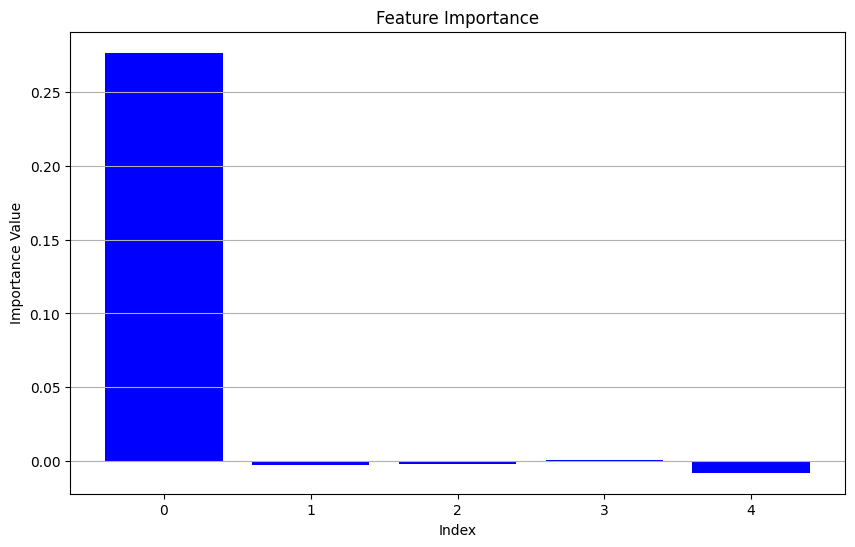

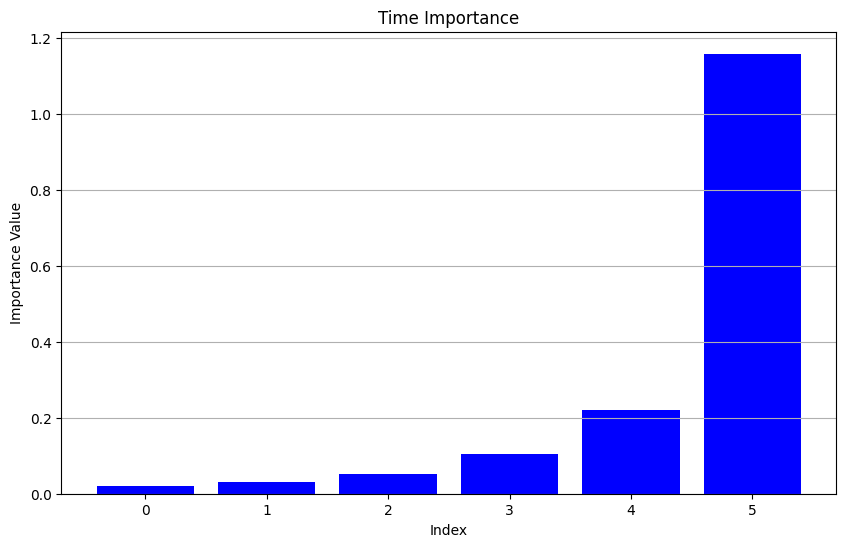

In [ ]:
import matplotlib.pyplot as plt

def plot_importance(importance_dict, title):
    # Extract keys and values from the dictionary
    keys = list(importance_dict.keys())
    values = list(importance_dict.values())

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='blue')
    plt.xlabel('Index')
    plt.ylabel('Importance Value')
    plt.title(title)
    plt.xticks(keys)  # Set x-ticks to be the keys for better readability
    plt.grid(axis='y')
    plt.show()

# Visualize feature_importance
plot_importance(feature_importance, 'Feature Importance')

# Visualize time_importance
plot_importance(time_importance, 'Time Importance')


### 특정 시간 + 특정 변수의 Shapley
이거는 average + 풀 버전. 너무 오래 걸린다.


조합의 경우의 수를 줄여봐야 겠다.

In [ ]:
import itertools
from math import factorial
# accuracy check functon
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

def modify_with_avg_except_for_combinations(x_test_seq, modified_combination,avg_values):
    modified_x_test_seq = np.copy(x_test_seq)

    for data_index in range(x_test_seq.shape[0]):
        for i in range(x_test_seq.shape[1]):
            for j in range(x_test_seq.shape[2]):
                if (i, j) not in modified_combination:
                    modified_x_test_seq[data_index, i, j] = 0 # avg_values[i, j]

    return modified_x_test_seq

# SHAP
# Train 단계에서의 SHAP가 아니라 predict 단계에서의 SHAP.
# RNN계열은 시계열의 의미가 퇴색될 수 있다.
def shap_LSTM(model, x_test_seq, y_test_seq, number, root_mean_squared_error):
  '''
  Parameters:
  model (LSTM)
  test data x, y
  number to calculate SHAP
  function to calculate the Value
  '''
  ''''============= Data ============='''
  # SHAP 계산에 쓸 개수만 남긴다.
  x_test_seq = x_test_seq[:number]
  y_test_seq = y_test_seq[:number]

  window_size = len(x_test_seq[0]) # 시계열 크기
  feature_num = len(x_test_seq[0][0]) # 설명 변수 개수
  avg_values = np.mean(x_test_seq, axis=0) # 대체할 평균

  locations = []
  locations_copy = []
  # 모든 변수의 location
  for i in range(window_size):
    for j in range(feature_num):
      locations.append((i,j))

  N = window_size * feature_num
  locations_copy =  locations.copy()

  # Factorial Dict 선언
  factorial_dict = {}
  for n in range(N):
    factorial_dict[n] = factorial(n)
  # v(K) - v(K/i) Dict 선언
  v_values_dict = {}

  ''''============= SHAP START !! ============='''
  # 각각 특성 i 의 shap (여기서 특성은 특정 시계열의 특정 설명 변수 의미)
  returning_shap = {}
  process = 0

  for loc in locations:

    process += 1
    # print("Now we are at: ", process/N * 100,"%")
    shap = 0
    locations_copy.remove(loc)
    # [0,1,2,N-2,N-1] 60개 경우의 수-> 5 분
    for K in [0,1,2,N-3,N-2,N-1]: # (N-2,N): original -> 불가능
      # every Combination Loop
      for combination in itertools.combinations(locations_copy, K):
        modified_combination = sorted(combination)
        # v(K/i)
        if tuple(modified_combination) not in v_values_dict:
          modified_data = modify_with_avg_except_for_combinations(x_test_seq, modified_combination, avg_values)
          pred_y = model.predict(modified_data, verbose=0)
          v_K_without_i = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict[tuple(modified_combination)] = v_K_without_i
        else:
          v_K_without_i = v_values_dict[tuple(modified_combination)]

        # v(K)
        modified_combination.append(loc)
        modified_combination = sorted(modified_combination)
        if tuple(modified_combination) not in v_values_dict:
          modified_x_test_seq = modify_with_avg_except_for_combinations(x_test_seq, modified_combination, avg_values)
          pred_y = model.predict(modified_x_test_seq, verbose=0)
          v_K = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict[tuple(modified_combination)] = v_K
        else:
          v_K = v_values_dict[tuple(modified_combination)]

        # i 가 포함된 것이니 원래 공식보다 K에 1 더한다
        factorial_n = factorial_dict[n]
        factorial_k_1 = factorial_dict[K]
        facotrial_n_k = factorial_dict[N-K-1]
        shap += ((factorial_k_1 * facotrial_n_k) / factorial_n) * ( v_K_without_i - v_K )

    # 다음에 또 쓰기 위해 다시 i 넣어준다.
    locations_copy.append(loc)
    returning_shap[loc] = shap
  return returning_shap


# model call
model.load_weights('best_model.h5')
# function call

result = shap_LSTM(model, x_test_seq, y_test_seq, 10, root_mean_squared_error)

result

{(0, 0): 0.018698291734535914,
 (0, 1): 0.002032753313200501,
 (0, 2): 0.008583993289834451,
 (0, 3): -0.008179074197025253,
 (0, 4): 0.006915399721591936,
 (1, 0): 0.03643338625392528,
 (1, 1): 0.0008569396217214173,
 (1, 2): 0.009154918181509344,
 (1, 3): -0.01017474962965751,
 (1, 4): 0.0027357465938535187,
 (2, 0): 0.0705416439695718,
 (2, 1): -0.0010521444140802194,
 (2, 2): 0.012855841340347635,
 (2, 3): -0.00983049166484932,
 (2, 4): 0.0015646621702405292,
 (3, 0): 0.12799537544221828,
 (3, 1): -0.0018009152536954433,
 (3, 2): 0.016915103030204895,
 (3, 3): -0.008025895461213222,
 (3, 4): -0.00021917541191915065,
 (4, 0): 0.2849895003814427,
 (4, 1): -0.003277886082139227,
 (4, 2): 0.023441324538639775,
 (4, 3): -0.007042774614872132,
 (4, 4): -0.0022770499828934808,
 (5, 0): 0.9901780165877957,
 (5, 1): -0.002391099624226867,
 (5, 2): 0.00042046312087352716,
 (5, 3): -0.007426294809618392,
 (5, 4): 0.0027983644767362566}

시각화

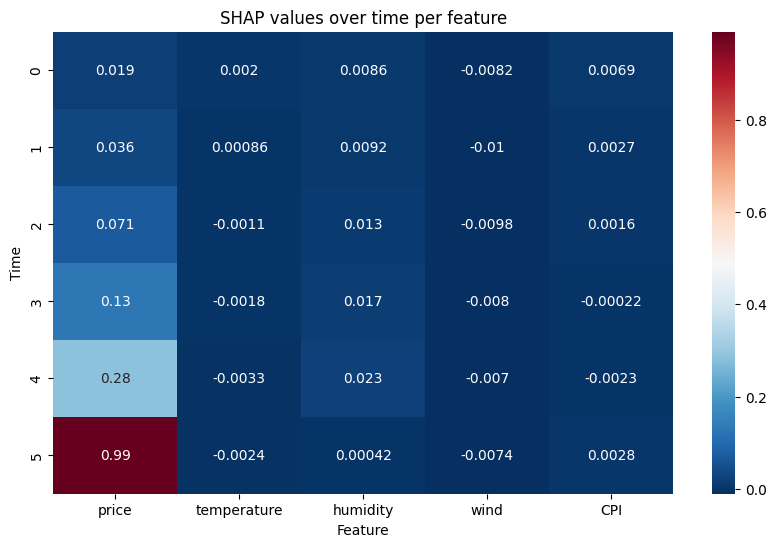

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

result_dict = result
feature_labels = ['price', 'temperature', 'humidity', 'wind', 'CPI']
# Convert dictionary to 2D array
n_time = max([key[0] for key in result_dict.keys()]) + 1
n_features = max([key[1] for key in result_dict.keys()]) + 1
data = np.zeros((n_time, n_features))

i = 0
for key, value in result_dict.items():
    data[key[0], key[1]] = value

df = pd.DataFrame(data, columns=feature_labels)
plt.figure(figsize=(10,6))
sns.heatmap(df, cmap="RdBu_r", annot=True)
plt.title("SHAP values over time per feature")
plt.xlabel("Feature")
plt.ylabel("Time")
plt.show()

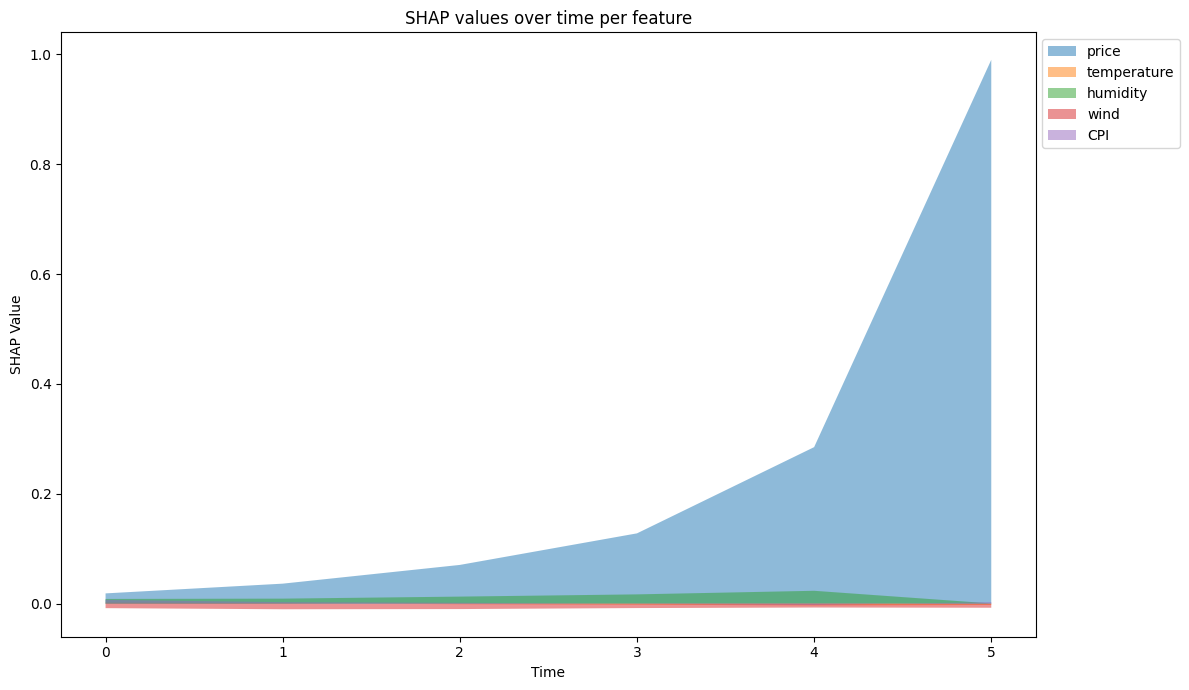

In [ ]:
# Custom feature labels
feature_labels = ['price', 'temperature', 'humidity', 'wind', 'CPI']

plt.figure(figsize=(12,7))
for feature in range(n_features):
    plt.fill_between(range(n_time), 0, data[:, feature], alpha=0.5, label=feature_labels[feature])

plt.title("SHAP values over time per feature")
plt.xlabel("Time")
plt.ylabel("SHAP Value")

# Adjust legend for better visibility
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout for legend
plt.tight_layout()

plt.show()

----------------------

In [ ]:
import itertools
from math import factorial
# accuracy check functon
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))


def modify_with_avg_except_for_combinations(x_test_seq, modified_combination,avg_values):
    modified_x_test_seq = np.copy(x_test_seq)

    for data_index in range(x_test_seq.shape[0]):
        for i in range(x_test_seq.shape[1]):
            for j in range(x_test_seq.shape[2]):
                if (i, j) not in modified_combination:
                    modified_x_test_seq[data_index, i, j] = avg_values[i, j]

    return modified_x_test_seq

# SHAP
# Train 단계에서의 SHAP가 아니라 predict 단계에서의 SHAP.
# RNN계열은 아예 train부터 빼면 시계열의 의미가 퇴색될 수 있다.
def shap_LSTM(model, x_test_seq, y_test_seq, number, root_mean_squared_error):
  '''
  Parameters:
  model (LSTM)
  test data x, y
  number to calculate SHAP
  function to calculate the Value
  '''
  ''''============= Data ============='''
  # SHAP 계산에 쓸 개수만 남긴다.
  x_test_seq = x_test_seq[:number]
  y_test_seq = y_test_seq[:number]

  window_size = len(x_test_seq[0]) # 시계열 크기
  feature_num = len(x_test_seq[0][0]) # 설명 변수 개수
  avg_values = np.mean(x_test_seq, axis=0) # 대체할 평균

  locations = []
  # 모든 변수의 location
  for i in range(window_size):
    for j in range(feature_num):
      locations.append((i,j))
  N = window_size * feature_num
  locations_copy = locations

  # Factorial Dict 선언
  factorial_dict = {}
  for n in range(N):
    factorial_dict[n] = factorial(n)
  # v(K) - v(K/i) Dict 선언
  v_values_dict = {}


  ''''============= SHAP START !! ============='''
  # 각각 특성 i 의 shap (여기서 특성은 특정 시계열의 특정 설명 변수 의미)
  returning_shap = {}
  process = 0
  for i in locations:
    process += 1
    print("Now we are at:", process/N * 100,"%")
    # i 는 항상 포함시킬 것이기 때문에 일단 빼고 뽑느다.
    shap = 0
    locations_copy.remove(i)
    for K in range(0,N):
      # every Combination Loop
      for combination in itertools.combinations(locations_copy, K):
        modified_combination = sorted(combination)

        # v(K/i)
        if tuple(modified_combination) not in v_values_dict:
          # list 로 바꿔야 하나 ?
          modified_data = modify_with_avg_except_for_combinations(x_test_seq, modified_combination, avg_values)
          pred_y = model.predict(modified_data, verbose=0)
          v_K_without_i = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict[tuple(modified_combination)] = v_K_without_i
        else:
          v_K_without_i = v_values_dict[modified_combination]

        # v(K)
        modified_combination.append(i)
        if tuple(modified_combination) not in v_values_dict:
          modified_x_test_seq = modify_with_avg_except_for_combinations(x_test_seq, modified_combination, avg_values)
          pred_y = model.predict(modified_x_test_seq, verbose=0)
          v_K = root_mean_squared_error(y_test_seq, pred_y)
          v_values_dict[tuple(modified_combination)] = v_K
        else:
          v_K = v_values_dict[tuple(modified_combination)]

        # i 가 포함된 것이니 원래 공식보다 K에 1 더한다
        factorial_n = factorial_dict[n]
        factorial_k_1 = factorial_dict[K]
        facotrial_n_k = factorial_dict[N-K-1]
        shap += ((factorial_k_1 * facotrial_n_k) / factorial_n) * (v_K - v_K_without_i)

    # 다음에 또 쓰기 위해 다시 i 넣어준다.
    locations_copy.append(i)
    returning_shap[i] = shap

  return returning_shap



# model call
model.load_weights('best_model.h5')
# function call

result = shap_LSTM(model, x_test_seq, y_test_seq, 10, root_mean_squared_error)

result

array([[[0.29285633, 0.22195704, 0.78828229, 0.09677419, 0.55237243],
        [0.29285673, 0.22911695, 0.58455393, 0.22580645, 0.55237243],
        [0.29285694, 0.22195704, 0.40878828, 0.29032258, 0.55237243],
        [0.29285714, 0.26491647, 0.63781625, 0.06451613, 0.55237243],
        [0.29285714, 0.23150358, 0.54593875, 0.25806452, 0.55237243],
        [0.32857143, 0.17899761, 0.55925433, 0.22580645, 0.55237243]],

       [[0.29285673, 0.22911695, 0.58455393, 0.22580645, 0.55237243],
        [0.29285694, 0.22195704, 0.40878828, 0.29032258, 0.55237243],
        [0.29285714, 0.26491647, 0.63781625, 0.06451613, 0.55237243],
        [0.29285714, 0.23150358, 0.54593875, 0.25806452, 0.55237243],
        [0.32857143, 0.17899761, 0.55925433, 0.22580645, 0.55237243],
        [0.32857143, 0.03579952, 0.60186418, 0.32258065, 0.55237243]]])